# 데이터 받는 예시 (Google Cloud Storage, GCS)

1. Shell에서 받기 (장점 : 속도가 조금더 빠름, 단점 : 원본사이즈 이미지임)
  1. Google Drive로 들어가서 Colaboratory로 다운받은 ipynb을 열거나, Colaboratory로 바로 들어가서 ipynb를 불러옴
  2. 공개해드린 GCS에서 gsutil(Google cloud sdk, local에서 설치가능) 을 써서 특정 폴더의 이미지 다운로드
    * 9633레이블의 이미지들 다운받기
    * ex) $gsutil -m cp -r gs://<bucket-name>/images/train/9633/*
2. Shell + Python 라이브러리를 통해 받기 (장점 : python library들을 통해 몇개 정도 받을지 정할수 있음, 단점 : 원본사이즈 이미지임=리사이즈해야함)
  1. 예제는 해당 섹션 참조
3. python 라이브러리를 통해 URL에서 resize하면서 받기
  1. 예제는 해당 섹션 참조

### Pytorch관련 라이브러리 다운로드
* Pytorch를 사용한 이유, Transferlearning 예제 공유
* Train Model ~ Train and evaluate는 Pytorch tutorial을 참조함

In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl

    100% |████████████████████████████████| 592.3MB 25.1MB/s 


In [0]:
!pip3 install torchvision

    100% |████████████████████████████████| 51kB 1.8MB/s 
    100% |████████████████████████████████| 5.9MB 234kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

    100% |████████████████████████████████| 5.6MB 237kB/s 
  Found existing installation: Pillow 5.0.0
    Uninstalling Pillow-5.0.0:
      Successfully uninstalled Pillow-5.0.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.1MB 202kB/s 


In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
%matplotlib inline

plt.ion()   # interactive mode

## Load Data

### Load Index file(.csv) From GCS(Google Cloud Storage)

In [0]:
!gsutil ls -al gs://<bucke-name>
!gsutil ls -al gs://<bucke-name>/images

In [0]:
!gsutil -m cp -r gs://<bucke-name>/train.csv .

### 1.Shell에서 받기

In [0]:
!gsutil -m cp -r gs://<bucke-name>/images/train/2743/* .

### 2.from GCS (Shell + Python)

In [0]:
!mkdir -p images/train/9633
!mkdir -p images/train/6051
!mkdir -p images/val/9633
!mkdir -p images/val/6051

In [0]:
import shlex, subprocess
from subprocess import call

def downloadFromGCS(df, path):
  for index, row in df.iterrows():
    command_line = 'gsutil -m cp gs://<bucke-name>/images/train/'+str(row['landmark_id'])+'/'+row['id']+'.jpg'+' ./images/'+path+'/'+str(row['landmark_id'])+'/'
    args = shlex.split(command_line)
    print(args)
    subprocess.Popen(args)


train_data = pd.read_csv('train.csv', names=['id','url','landmark_id'])
downloadFromGCS(train_data[train_data["landmark_id"] == 9633].take(range(0,20)), 'train')
downloadFromGCS(train_data[train_data["landmark_id"] == 6051].take(range(0,20)), 'train')
downloadFromGCS(train_data[train_data["landmark_id"] == 9633].take(range(20,21)), 'val')
downloadFromGCS(train_data[train_data["landmark_id"] == 6051].take(range(20,21)), 'val')

### 3.python 라이브러리를 통해 URL에서 resize하면서 받기

In [0]:
train_data = pd.read_csv('train.csv', names=['id','url','landmark_id'])
l9633 = train_data[train_data["landmark_id"] == 9633].take(range(0,1000))
l6051 = train_data[train_data["landmark_id"] == 6051].take(range(0,1000))
frames = [l9633, l6051]
pd.concat(frames).to_csv("train_tmp.csv", header=False, index=False)

l9633 = train_data[train_data["landmark_id"] == 9633].take(range(1000,2000))
l6051 = train_data[train_data["landmark_id"] == 6051].take(range(1000,2000))
frames = [l9633, l6051]
pd.concat(frames).to_csv("train_val.csv", header=False, index=False)

In [0]:
import sys, os, multiprocessing, csv
from urllib import request, error
from PIL import Image
from io import BytesIO

def parse_data(data_file):
    csvfile = open(data_file, 'r')
    csvreader = csv.reader(csvfile)
    key_url_list = [line for line in csvreader]
    return key_url_list[1:]  # Chop off header
  
def download_image(key_url):

    (key, url, label) = key_url
    
    subfolder = os.path.join(out_dir, label)
    if not os.path.exists(subfolder):
      os.makedirs(subfolder)
      
    filename = os.path.join(subfolder, '{}.jpg'.format(key))

    if os.path.exists(filename):
        print('Image {} already exists. Skipping download.'.format(filename))
        return

    try:
        response = request.urlopen(url)
        image_data = response.read()
    except:
        print('Warning: Could not download image {} from {}'.format(key, url))
        return

    try:
        pil_image = Image.open(BytesIO(image_data))
    except:
        print('Warning: Failed to parse image {}'.format(key))
        return

    try:
        size = 256, 256
        pil_image.thumbnail(size)
    except:
        print('Warning: Failed to resize image {} to {}x{}'.format(key, size[0], size[1]))
        return
      
    try:
        pil_image_rgb = pil_image.convert('RGB')
    except:
        print('Warning: Failed to convert image {} to RGB'.format(key))
        return
      
    try:
        pil_image_rgb.save(filename, format='jpeg', quality=90)
    except:
        print('Warning: Failed to save image {}'.format(filename))
        return
      
def loader(data_file, out_dir):

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    key_url_list = parse_data(data_file)
    pool = multiprocessing.Pool(processes=4)  # Num of CPUs
    pool.map(download_image, key_url_list)
    pool.close()
    pool.terminate()

In [0]:
out_dir = "images/train"
loader("train_tmp.csv", out_dir)
out_dir = "images/val"
loader("train_val.csv", out_dir)

## Making "train" and "val" set

Pytorch에서 input Variable을 만들기위해 Torch.utils.data.DataLoader를 만들어줄때, 

image파일 path가 [data_dir = images] > [train or val] > [label = 9655] > xxx.jpg 식으로 데이터가 들어가있어야 파싱이 정상적으로 됨

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'images'
image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

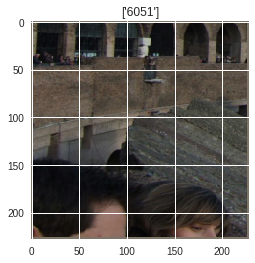

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train model

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

## Finetuning the convnet

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4028 Acc: 0.3750
val Loss: 0.5280 Acc: 0.5000

Epoch 1/24
----------
train Loss: 2.1890 Acc: 0.5750
val Loss: 1.8125 Acc: 0.5000

Epoch 2/24
----------
train Loss: 1.2128 Acc: 0.3500
val Loss: 0.4024 Acc: 0.5000

Epoch 3/24
----------
train Loss: 1.6106 Acc: 0.5000
val Loss: 1.1319 Acc: 0.5000

Epoch 4/24
----------
train Loss: 1.2824 Acc: 0.4000
val Loss: 1.4711 Acc: 0.5000

Epoch 5/24
----------
train Loss: 0.9940 Acc: 0.3250
val Loss: 0.4199 Acc: 1.0000

Epoch 6/24
----------
train Loss: 1.3410 Acc: 0.4500
val Loss: 0.4913 Acc: 0.5000

Epoch 7/24
----------
train Loss: 0.7403 Acc: 0.5500
val Loss: 0.4487 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.6926 Acc: 0.4500
val Loss: 0.2596 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.7135 Acc: 0.5000
val Loss: 0.3196 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.7676 Acc: 0.4000
val Loss: 0.3815 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.7805 Acc: 0.3500
val Loss: 0.6849 Acc: 0.5000

Ep

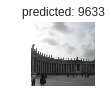

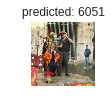

In [0]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [0]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 2)

# if use_gpu:
#     model_ft = model_ft.cuda()

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.9404 Acc: 0.5000
val Loss: 4.2291 Acc: 0.5000

Epoch 1/24
----------
train Loss: 2.3315 Acc: 0.5500
val Loss: 4.1418 Acc: 0.5000

Epoch 2/24
----------
train Loss: 1.7327 Acc: 0.4250
val Loss: 1.1592 Acc: 0.5000

Epoch 3/24
----------
train Loss: 1.4271 Acc: 0.6750
val Loss: 2.5913 Acc: 0.5000

Epoch 4/24
----------
train Loss: 1.1240 Acc: 0.5000
val Loss: 1.1136 Acc: 0.5000

Epoch 5/24
----------
train Loss: 2.0847 Acc: 0.3750
val Loss: 2.3192 Acc: 0.5000

Epoch 6/24
----------
train Loss: 1.0164 Acc: 0.5000
val Loss: 1.0033 Acc: 0.0000

Epoch 7/24
----------
train Loss: 0.7332 Acc: 0.5750
val Loss: 1.3875 Acc: 0.5000

Epoch 8/24
----------
train Loss: 0.7278 Acc: 0.4000
val Loss: 1.4496 Acc: 0.5000

Epoch 9/24
----------
train Loss: 0.7257 Acc: 0.5250
val Loss: 0.9478 Acc: 0.0000

Epoch 10/24
----------
train Loss: 0.7803 Acc: 0.5750
val Loss: 0.9677 Acc: 0.0000

Epoch 11/24
----------
train Loss: 0.7332 Acc: 0.5000
val Loss: 1.0905 Acc: 0.0000

Ep

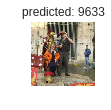

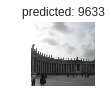

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()